# Appendix

# Source Code

# Nested Simulation using Uniform VaR and OCBA scheme

**Test Code based on Lin et al (2020) 'A NESTED SIMULATION OPTIMIZATION APPROACH FOR PORTFOLIO SELECTION' Proceedings of the 2020 Winter Simulation Conference
K.-H. Bae, B. Feng, S. Kim, S. Lazarova-Molnar, Z. Zheng, T. Roeder, and R. Thiesing, eds.**

**Please directly go to Real World Data Simulation**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import SimFunctions
import SimRNG 
import SimClasses
from statistics import NormalDist

# Creating a function to generate sample path based on a Geometric Brownian Motion
def sample_path(x0, x, X, S0, r, T, t, c, mu, sigma, O):
    St = S0*np.exp((mu - (sigma**2)/2)*t + sigma*(t**0.5)*O)
    W = SimRNG.Normal(0,1,2)
    ST = St*np.exp((r - (sigma**2)/2)*(T - t) + sigma*((T - t)**0.5)*W)
    ht = x*X*(1 - np.exp(-r*(T - t)*(ST/S0))) + c*(x - x0)**(2)
    return ht
 
# Analytcan Method to calculate Value at Risk
def analytical_Var(x0, x, X, S0, r, T, t, c, mu, sigma):
    z = NormalDist().inv_cdf(0.90)
    a = (mu - ((sigma)**2/2))*t + (z*sigma*np.sqrt(t)) 
    Vi = x*X*(1 - np.exp(-a)) + c*(x - x0)**(2)
    return Vi

# Test Equal Allocation algorithm
def equal_allocation(weights_list, N, K):
    np.random.seed(1)
    v = []
    for i in weights_list:
        vi = []
        for n in range(0 , N):
            O = SimRNG.Normal(0,1,1)
            h = []
            for k in range(0 , K):
                ht = sample_path(x0=0.5, x=i, X=3, S0=0.1, r=0.1, T=0.25, t=1/52, c=1, mu=0.08, sigma=0.1, O=O)
                h.append(ht)
            #print(h)
            vi.append(np.mean(h))
        #print(vi)
        sorted_vi = sorted(vi)
        #print(sorted_vi)
        v.append(sorted_vi[int(np.floor(0.90*N))])
    u = weights_list[v.index(min(v))]
    #return u
    print('The lowest Value-at-risk:', min(v), 'for weight:',u)
    print('Total simulation budget used:', len(weights_list)*N*K)

In [2]:
w = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
equal_allocation(w, N=10, K=40)

The lowest Value-at-risk: 0.03648832026695493 for weight: 0.5
Total simulation budget used: 4000


In [3]:
Vr = []
for i in w:
    r = analytical_Var(x0=0.5, x=i, X=3, S0=0.1, r=0.1, T=0.25, t=1/52, c=1, mu=0.08, sigma=0.1)
    Vr.append(r)
print('The best portfolio weight based on analytical calculation of Value at Risk:', w[Vr.index(min(Vr))])

The best portfolio weight based on analytical calculation of Value at Risk: 0.5


In [4]:
from scipy.stats import gaussian_kde
fvr = gaussian_kde(Vr)

In [5]:
def correct_selection_equal_allocation(Mn,cv,weights_list, Tb, K):
    np.random.seed(1)
    u = []
    N = int(np.floor(Tb/K))
    for j in range(0,Mn):
        v = []
        for i in weights_list:
            vi = []
            for n in range(0 , N):
                O = SimRNG.Normal(0,1,1)
                h = []
                for k in range(0 , K):
                    ht = sample_path(x0=0.5, x=i, X=3, S0=0.1, r=0.1, T=0.25, t=1/52, c=1, mu=0.08, sigma=0.1, O=O)
                    h.append(ht)
                #print(h)
                vi.append(np.mean(h))
            #print(vi)
            sorted_vi = sorted(vi)
            #print(sorted_vi)
            v.append(sorted_vi[int(np.floor(0.90*N))])
        #print(v)
        ui = weights_list[v.index(min(v))]
        u.append(ui)
    
    def prob(u,cv):
        I = []
        for i in u:
            if i == cv:
                I.append(1)
            else:
                I.append(0)
        return(sum(I)/len(u))
    
    p = prob(u,cv)
    return p
    
    #print('The probability of correct selection for equal allocation:', prob(u,cv))

In [6]:
P = []
a=[400]
for i in a:
    p = correct_selection_equal_allocation(Mn = 500, cv = 0.5, weights_list = w, Tb = i, K = 40)
    P.append(p)
print(P)

[1.0]


In [7]:
# Prototype OCBA uniform VaR algorithm
def ocba_uniform(weights_list, Tb, N0, K, d):
    np.random.seed(1)
    v = []
    bias = []
    variance = []
    new_count = [N0]*len(weights_list)
    last_count =  [N0]*len(weights_list)
    h_mean = [[] for i in range(len(weights_list))]
    sn_ratio = [0 for i in range(len(weights_list))]
    all_ratio = [0 for i in range(len(weights_list))]
    l = 0
    for i in range(len(weights_list)):
        for n in range(0 , new_count[i]):
            O = SimRNG.Normal(0,1,1)
            h = []
            for k in range(0 , K):
                ht = sample_path(x0=0.5, x=weights_list[i], X=3, S0=0.1, r=0.1, T=0.25, t=1/52, c=1, mu=0.08, sigma=0.1, O=O)
                h.append(ht)
            h_mean[i].append(np.mean(h))
        sorted_vi = sorted(h_mean[i])
        v_alpha = sorted_vi[int(np.floor(0.90*new_count[i]))]
        v.append(v_alpha)
        bias.append(np.mean(h_mean[i]))
        variance.append(np.var(h_mean[i]))
    Tu = np.sum(last_count)*(K)
    
    while Tu < Tb:
        bk = [i / K for i in bias]
        b_list = []
        for e in range(len(v)):
            b_list.append(v[e] - bk[e])
        b = np.argmin(b_list)
        b_factor =0
        for j in range(len(weights_list)):
            if j == b:
                continue
            else:
                sn_ratio[j] = variance[j] / (bias[b] - bias[j]) ** 2
                b_factor += (sn_ratio[j])**2 / variance[j]
        sn_ratio[b] = np.sqrt(variance[b]) * np.sqrt(b_factor)
        sum_sn_ratio = np.sum(np.array(sn_ratio))
        sum_last_count = np.sum(np.array(last_count))
        
        for wts in range(len(weights_list)):
            all_ratio[wts] = sn_ratio[wts] / sum_sn_ratio
            new_count[wts] = all_ratio[wts] * (d + sum_last_count)


        for i in range(len(weights_list)):
            for n in range(int(np.floor(max(new_count[i] - last_count[i],0)))):
                O = SimRNG.Normal(0,1,1)
                h = []
                for k in range(0 , K):
                    ht = sample_path(x0=0.5, x=weights_list[i], X=3, S0=0.1, r=0.1, T=0.25, t=1/52, c=1, mu=0.08, sigma=0.1, O=O)
                    h.append(ht)
                h_mean[i].append(np.mean(h)) 
            sorted_vi = sorted(h_mean[i])
            v_alpha = sorted_vi[int(np.floor(0.90*len(h_mean[i])))]
            v[i] = v_alpha
            bias[i] = np.mean(h_mean[i])
            variance[i] = np.var(h_mean[i])
        last_count = new_count
        l = l + 1
        Tu = np.sum(last_count)*(K)
    
    print('The lowest Value-at-risk:', min(v), 'for weight:', weights_list[v.index(min(v))])
    print('Total simulation budget used:', Tb)

In [8]:
w = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
ocba_uniform(w, Tb=40000, N0=10, K=40, d=10)

The lowest Value-at-risk: 0.03566325944603143 for weight: 0.5
Total simulation budget used: 40000


# Performing the Equal Allocation and Optimal Budget Allocation Scheme on Real World Stock Data

In [9]:
#Import Fed Rate data from the mentioned time period
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fr = pd.read_csv('FedRates17-19.csv', header = 'infer')
effr = fr['Federal Funds Data.2'][5:757].tolist()

In [10]:
df = pd.DataFrame(effr, columns=['EFFR'])
display(df)

,EFFR
0,1.55
1,1.55
2,1.55
3,1.55
4,1.55
...,...
747,0.66
748,0.66
749,0.66
750,0.66


In [6]:
#df.to_csv('EFFR.csv', index = False)

In [11]:
#Import the Apple stock data for the mentioned time period from yahoo finance
#!pip install yahoo-fin
import yahoo_fin.stock_info as si

prices = si.get_data(ticker = 'AAPL', start_date='04/01/2017', end_date='31/12/2019')
display(prices)

,open,high,low,close,adjclose,volume,ticker
2017-04-03,35.927502,36.029999,35.762501,35.924999,34.120541,79942800,AAPL
2017-04-04,35.812500,36.222500,35.792500,36.192501,34.374607,79565600,AAPL
2017-04-05,36.055000,36.365002,35.952499,36.005001,34.196522,110871600,AAPL
2017-04-06,36.072498,36.130001,35.862499,35.915001,34.111042,84596000,AAPL
2017-04-07,35.932499,36.044998,35.817501,35.834999,34.035061,66688800,AAPL
...,...,...,...,...,...,...,...
2019-12-23,70.132500,71.062500,70.092499,71.000000,70.287064,98572000,AAPL
2019-12-24,71.172501,71.222504,70.730003,71.067497,70.353882,48478800,AAPL
2019-12-26,71.205002,72.495003,71.175003,72.477501,71.749733,93121200,AAPL
2019-12-27,72.779999,73.492500,72.029999,72.449997,71.722488,146266000,AAPL


In [12]:
#Calculating the volatility and mean price
stock_price = prices['adjclose']
mean_price = stock_price.mean()
vol_daily = stock_price.std()
vol_annual = np.sqrt(252)*vol_daily

print("The average stock price for apple from 01/01/2017 to 31/12/2019:",mean_price)
print("The daily volatility for apple from 01/01/2017 to 31/12/2019:",vol_daily)
print("The annual volatility for apple from 01/01/2017 to 31/12/2019:",vol_annual)

The average stock price for apple from 01/01/2017 to 31/12/2019: 45.45603428356209
The daily volatility for apple from 01/01/2017 to 31/12/2019: 8.211236872130627
The annual volatility for apple from 01/01/2017 to 31/12/2019: 130.34934431940908


In [13]:
#Calculating S0 which is adjusted close price for the last date
S0 = float(stock_price[-1])
print(S0)

72.14817810058594


In [211]:
#Equal Allocation with Uniform VaR for AAPL stock
def equal_allocation_real(weights_list, N, K):
    np.random.seed(1)
    v = []
    s = []
    for i in weights_list:
        vi = []
        for n in range(0 , N):
            O = float(np.random.choice(effr, 1, replace=True)[0])
            h = []
            for k in range(0 , K):
                ht = sample_path(x0=0.5, x=i, X=3, S0=float(S0), r=0.1, T=0.25, t=1/52, c=1, mu=float(mean_price), sigma=float(vol_daily), O=O)
                h.append(ht)
            #print(h)
            vi.append(np.mean(h))
        #print(vi)
        sorted_vi = sorted(vi)
        #print(sorted_vi)
        v.append(sorted_vi[int(np.floor(0.90*N))])
        si  = []
        for a in vi:
            si.append((a - sorted_vi[int(np.floor(0.90*N))])**2)
        s.append(np.sqrt(np.mean(si)))
    #print(v)
    u = weights_list[v.index(min(v))]
    #return u
    print('The lowest Value-at-risk:', min(v), 'for weight:',u)
    print('Total simulation budget used:', len(weights_list)*N*K)
    return v, s

In [216]:
w = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
v_ea, s_ea = equal_allocation_real(w, N=1000, K=100)

The lowest Value-at-risk: 0.051883058075916415 for weight: 0.4
Total simulation budget used: 1000000


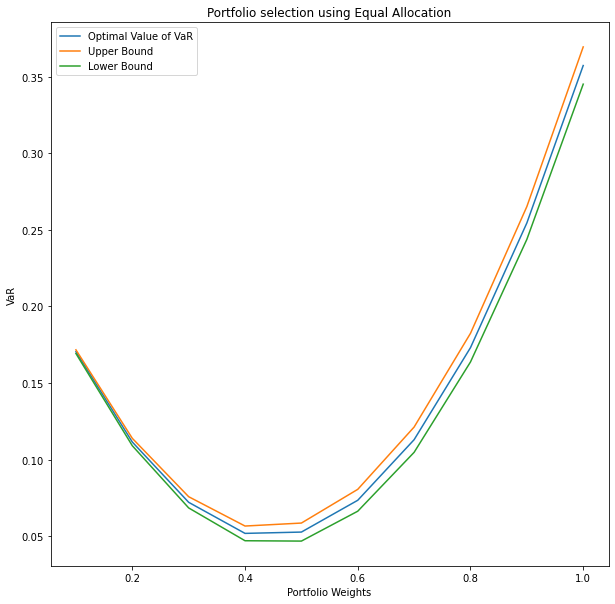

In [219]:
#Ploting the optimal VaR based on Equal Allocation with 100000 total budget
ub_ea = []
lb_ea = []
for i in range(len(v_ea)):
    ub_ea.append(v_ea[i] + 1.96*s_ea[i] / np.sqrt(n))
    lb_ea.append(v_ea[i] - 1.96*s_ea[i] / np.sqrt(n))
plt.plot(w, v_ea, label='Optimal Value of VaR')
plt.plot(w, ub_ea, label='Upper Bound')
plt.plot(w, lb_ea, label='Lower Bound')
plt.xlabel('Portfolio Weights')
plt.ylabel('VaR')
plt.title('Portfolio selection using Equal Allocation')
plt.legend()
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})
plt.show()

In [16]:
#Probability of Correct Selection
def prob(u,cv):
        I = []
        for i in u:
            if i == cv:
                I.append(1)
            else:
                I.append(0)
        return(sum(I)/len(u))

In [186]:
#Calculating the porbability of correct selection using Equal Allocation
def correct_selection_equal_allocation_real(Mn,cv,weights_list, Tb, K):
    np.random.seed(1)
    u = []
    N = int(np.floor(Tb/K))
    for j in range(0,Mn):
        v = []
        for i in weights_list:
            vi = []
            for n in range(0 , N):
                O = float(np.random.choice(effr, 1, replace=True)[0])
                h = []
                for k in range(0 , K):
                    ht = sample_path(x0=0.5, x=i, X=3, S0=float(S0), r=0.1, T=0.25, t=1/52, c=1, mu=float(mean_price), sigma=float(vol_daily), O=O)
                    h.append(ht)
                #print(h)
                vi.append(np.mean(h))
            #print(vi)
            sorted_vi = sorted(vi)
            #print(sorted_vi)
            v.append(sorted_vi[int(np.floor(0.90*N))])
        #print(v)
        ui = weights_list[v.index(min(v))]
        u.append(ui)
    
    p = prob(u,cv)
    return p
    
    #print('The probability of correct selection for equal allocation:', prob(u,cv))

In [187]:
P = []
a = np.arange(10000,60000,10000)
for i in a:
    p = correct_selection_equal_allocation_real(Mn = 500, cv = 0.4, weights_list = w, Tb = i, K = 40)
    P.append(p)
print(P)

[0.704, 0.694, 0.77, 0.818, 0.866]


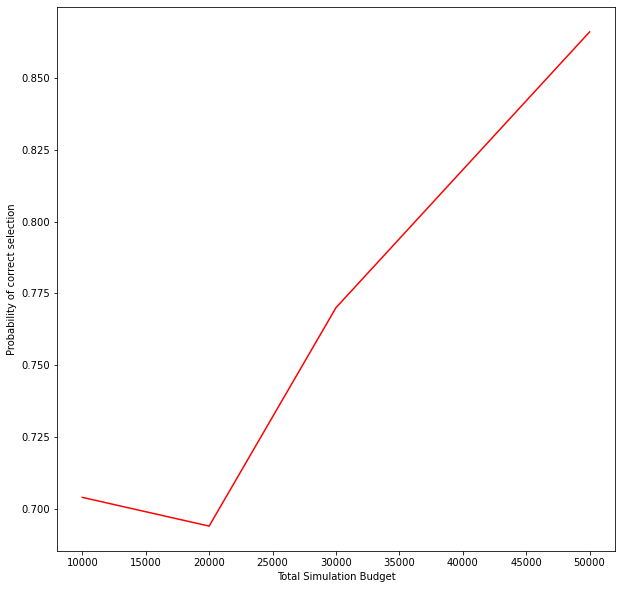

In [221]:
#Plotting the change in PCS with increase in total simulation budget
plt.plot(a,P,'-r')
plt.xlabel('Total Simulation Budget')
plt.ylabel("Probability of correct selection")
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})
plt.show()

**For the OCBA Uniform VaR:
We need to calculte the sample estimate of bias and standard deviation/variance using theorem 1 mentioedn in the report. To do so we need to two things:**  
**1. the probability density function of VaR estimator**  
**2. conditional expectation of second moment of performance measure**  
**To do so we can generate a lot samples of VaR ,perfromance measure and second moment of performance measure. to calculate the conditional expectation we perfroma polynomial regression as mentioned in Zhang et al (2020) between performamnce measure and its second momenta dn the output is a regression function of polynomial degree 2.    
To calculate the pdf of VaR estimator we use guassian kde on the VaR samples.  
Note: Here all the different type of samples are generated for each distinct value of portfolio weights used in the simulation and experiment and we must perform the regressiona and pdf estimation for samples generated for each portfolio weight.  
One issue is calcualting the A'(t) is that guassian kde can not be differentiated using sympy hence we will have to fit the VaR samples for each weight into a normal distribution and using the mean and std paramaters estimated from fitted normal distribution and our knowledge of the pdf function for a normal distribution we get an expression for f(t) which can be differentiaited using sympy. However in the OCBA algorithm when need to use the value of f(t) we using the pdf from gaussian kde to get the value.**

In [18]:
# Calculating the conditional expectation and the probability density function
from scipy.stats import moment
w = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
v = [[] for i in range(len(w))]
H20 = [[] for i in range(len(w))]
h0 = [[] for i in range(len(w))]
for j in range(100):
    for i in range(len(w)):
        vi = []
        for n in range(0 , 100):
            O = float(np.random.choice(effr, 1, replace=True)[0])
            h = []
            for k in range(0 , 40):
                ht = sample_path(x0=0.5, x=w[i], X=3, S0=float(S0), r=0.1, T=0.25, t=1/52, c=1, mu=float(mean_price), sigma=float(vol_daily), O=O)
                h.append(ht)
            vi.append(np.mean(h))
            h0[i].append(np.mean(h))
            H20[i].append(moment(h,  moment=2))
        sorted_vi = sorted(vi)
        v[i].append(sorted_vi[int(np.floor(0.90*100))])

In [19]:
# Creating a dataframe for generated VaR values which will be used for fitting distribution
dv = pd.DataFrame(v[0], columns=['VaR_0.1'])
for i in w:
    if i != 0.1:
        dv['VaR_' + str(i)] = v[w.index(i)]
display(dv)
dv.to_csv('Var.csv', index = False)

,VaR_0.1,VaR_0.2,VaR_0.3,VaR_0.4,VaR_0.5,VaR_0.6,VaR_0.7,VaR_0.8,VaR_0.9,VaR_1
0,0.174895,0.116658,0.078827,0.054795,0.070760,0.105861,0.130363,0.193714,0.269713,0.363916
1,0.174855,0.114096,0.081933,0.058273,0.085532,0.079199,0.138956,0.202445,0.271591,0.372671
2,0.173197,0.111953,0.077182,0.054173,0.056099,0.100342,0.115560,0.184751,0.296757,0.373194
3,0.171988,0.118661,0.075951,0.059936,0.057205,0.097857,0.120174,0.190571,0.267728,0.360449
4,0.173182,0.110297,0.079836,0.063479,0.059383,0.086186,0.124094,0.170458,0.274862,0.366323
...,...,...,...,...,...,...,...,...,...,...
95,0.172106,0.117911,0.078282,0.055062,0.060776,0.091366,0.141825,0.191743,0.302001,0.387324
96,0.171833,0.118111,0.070628,0.059066,0.061101,0.071757,0.118976,0.186069,0.283479,0.383128
97,0.171669,0.114202,0.075605,0.055167,0.073691,0.084070,0.127554,0.195323,0.272252,0.386055
98,0.174674,0.117651,0.072470,0.060220,0.049043,0.082004,0.120171,0.186397,0.270053,0.379978


In [20]:
# Calculating the pdf of the VaR using gaussian kde
from scipy.stats import gaussian_kde
f = []
for i in range(len(w)):
    f.append(gaussian_kde(v[i]))
display(f)

In [47]:
# Calculating the conditional expected value of second moment by performing a polynomial regression and plotting the figure
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def conditional_expectation(i,h0,H20, degree):
    poly_reg = PolynomialFeatures(degree=degree)
    h0_poly = poly_reg.fit_transform(np.array(h0[i]).reshape(-1,1))
    lin_reg2 = LinearRegression()
    lin_reg2.fit(h0_poly,H20[i])

    h0_grid = np.arange(min(h0[i]),max(h0[i]),0.01)
    h0_grid = h0_grid.reshape(len(h0_grid),1) 
    plt.scatter(h0[i],H20[i], color='red') 

    plt.plot(h0_grid, lin_reg2.predict(poly_reg.fit_transform(h0_grid)), color='blue') 

    plt.title("Polynomial Regression to find E[t^2(0)|H(0) = t]")
    plt.xlabel('H(0)')
    plt.ylabel('H^2(0)')
    plt.show()
    p3 = lin_reg2.coef_
    return p3

In [73]:
lambda_cap = []

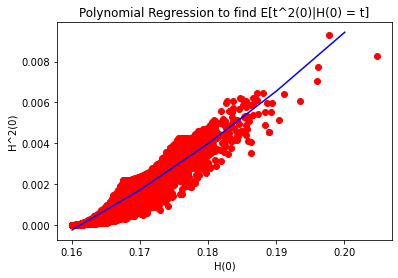

In [74]:
p3 = conditional_expectation(i = 0,h0 = h0,H20 = H20, degree = 2)

In [75]:
# Differentiation of the lmabda function using the gression coefficients and the mean and std values from fitted normal distribution in R
#!pip install sympy
import sympy as sym
V = sym.symbols('v_alpha')
equation = sym.exp(-0.5*((V - 0.172758746)/0.1477041)**2)*(p3[0]+ p3[1]*(V) + p3[2]*(V**2))/(np.sqrt(2*3.14)*0.1477041)
dx = sym.diff(equation,V)
A = format(dx)
print('After differentiation:',A)
lambda_cap.append(A)

After differentiation: (7.91871917308214 - 45.8368641613209*v_alpha)*(4.07392709552467*v_alpha**2 - 0.812570606242662*v_alpha)*exp(-22.9184320806604*(v_alpha - 0.172758746)**2) + (8.14785419104934*v_alpha - 0.812570606242662)*exp(-22.9184320806604*(v_alpha - 0.172758746)**2)


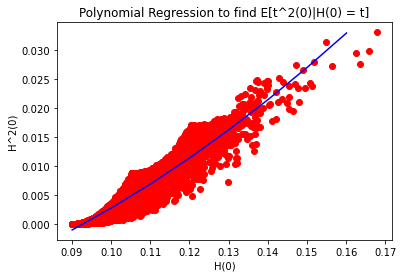

In [76]:
p3 = conditional_expectation(i = 1,h0 = h0,H20 = H20, degree = 2)

In [77]:
# Differentiation of the lmabda function using the gression coefficients and the mean and std values from fitted normal distribution in R
V = sym.symbols('v_alpha')
equation = sym.exp(-0.5*((V - 0.115514660)/0.2585072)**2)*(p3[0]+ p3[1]*(V) + p3[2]*(V**2))/(np.sqrt(2*3.14)*0.2585072)
dx = sym.diff(equation,V)
A = format(dx)
print('After differentiation:',A)
lambda_cap.append(A)

After differentiation: (1.72858928589852 - 14.9642416460258*v_alpha)*(2.73017166842005*v_alpha**2 + 0.0669845713981754*v_alpha)*exp(-7.48212082301292*(v_alpha - 0.11551466)**2) + (5.46034333684009*v_alpha + 0.0669845713981754)*exp(-7.48212082301292*(v_alpha - 0.11551466)**2)


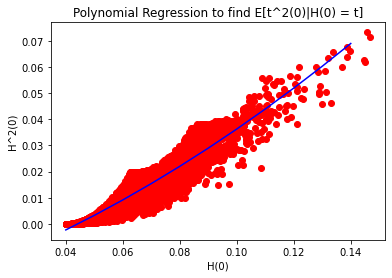

In [78]:
p3 = conditional_expectation(i = 2,h0 = h0,H20 = H20, degree = 2)

In [79]:
# Differentiation of the lmabda function using the gression coefficients and the mean and std values from fitted normal distribution in R
V = sym.symbols('v_alpha')
equation = sym.exp(-0.5*((V - 0.077888465)/0.4484606)**2)*(p3[0]+ p3[1]*(V) + p3[2]*(V**2))/(np.sqrt(2*3.14)*0.4484606)
dx = sym.diff(equation,V)
A = format(dx)
print('After differentiation:',A)
lambda_cap.append(A)

After differentiation: (0.387279543504849 - 4.97223232611979*v_alpha)*(1.55363538516144*v_alpha**2 + 0.35403820433075*v_alpha)*exp(-2.48611616305989*(v_alpha - 0.077888465)**2) + (3.10727077032287*v_alpha + 0.35403820433075)*exp(-2.48611616305989*(v_alpha - 0.077888465)**2)


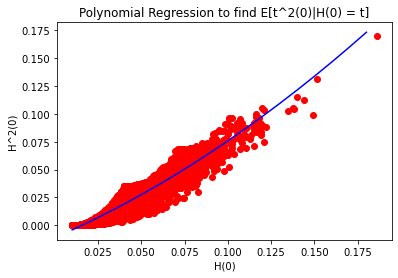

In [80]:
p3 = conditional_expectation(i = 3,h0 = h0,H20 = H20, degree = 2)

In [81]:
# Differentiation of the lmabda function using the gression coefficients and the mean and std values from fitted normal distribution in R
V = sym.symbols('v_alpha')
equation = sym.exp(-0.5*((V - 0.059797197)/0.5409998)**2)*(p3[0]+ p3[1]*(V) + p3[2]*(V**2))/(np.sqrt(2*3.14)*0.5409998)
dx = sym.diff(equation,V)
A = format(dx)
print('After differentiation:',A)
lambda_cap.append(A)

After differentiation: (0.204308585840454 - 3.41669168607441*v_alpha)*(1.42655766307635*v_alpha**2 + 0.49752929845689*v_alpha)*exp(-1.7083458430372*(v_alpha - 0.059797197)**2) + (2.8531153261527*v_alpha + 0.49752929845689)*exp(-1.7083458430372*(v_alpha - 0.059797197)**2)


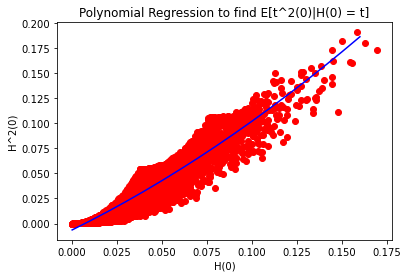

In [82]:
p3 = conditional_expectation(i = 4,h0 = h0,H20 = H20, degree = 2)

In [83]:
# Differentiation of the lmabda function using the gression coefficients and the mean and std values from fitted normal distribution in R
V = sym.symbols('v_alpha')
equation = sym.exp(-0.5*((V - 0.063575787)/0.6311232)**2)*(p3[0]+ p3[1]*(V) + p3[2]*(V**2))/(np.sqrt(2*3.14)*0.6311232)
dx = sym.diff(equation,V)
A = format(dx)
print('After differentiation:',A)
lambda_cap.append(A)

After differentiation: (0.159611233842899 - 2.51056638658518*v_alpha)*(1.26140678895264*v_alpha**2 + 0.560686342259076*v_alpha)*exp(-1.25528319329259*(v_alpha - 0.063575787)**2) + (2.52281357790528*v_alpha + 0.560686342259076)*exp(-1.25528319329259*(v_alpha - 0.063575787)**2)


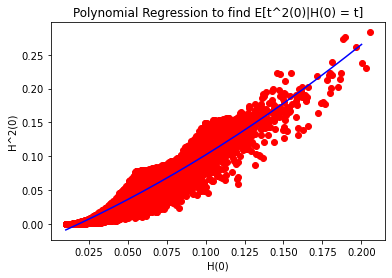

In [84]:
p3 = conditional_expectation(i = 5,h0 = h0,H20 = H20, degree = 2)

In [85]:
# Differentiation of the lmabda function using the gression coefficients and the mean and std values from fitted normal distribution in R
V = sym.symbols('v_alpha')
equation = sym.exp(-0.5*((V - 0.08640510)/0.816312)**2)*(p3[0]+ p3[1]*(V) + p3[2]*(V**2))/(np.sqrt(2*3.14)*0.816312)
dx = sym.diff(equation,V)
A = format(dx)
print('After differentiation:',A)
lambda_cap.append(A)

After differentiation: (0.129666269265602 - 1.50067842367641*v_alpha)*(1.01813617812472*v_alpha**2 + 0.490557990037473*v_alpha)*exp(-0.750339211838204*(v_alpha - 0.0864051)**2) + (2.03627235624944*v_alpha + 0.490557990037473)*exp(-0.750339211838204*(v_alpha - 0.0864051)**2)


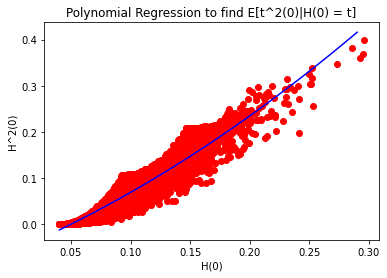

In [86]:
p3 = conditional_expectation(i = 6,h0 = h0,H20 = H20, degree = 2)

In [87]:
# Differentiation of the lmabda function using the gression coefficients and the mean and std values from fitted normal distribution in R
V = sym.symbols('v_alpha')
equation = sym.exp(-0.5*((V - 0.128976535)/0.9851987)**2)*(p3[0]+ p3[1]*(V) + p3[2]*(V**2))/(np.sqrt(2*3.14)*0.9851987)
dx = sym.diff(equation,V)
A = format(dx)
print('After differentiation:',A)
lambda_cap.append(A)

After differentiation: (0.132881048137319 - 1.03027305034453*v_alpha)*(0.749278990818032*v_alpha**2 + 0.446140021828102*v_alpha)*exp(-0.515136525172267*(v_alpha - 0.128976535)**2) + (1.49855798163606*v_alpha + 0.446140021828102)*exp(-0.515136525172267*(v_alpha - 0.128976535)**2)


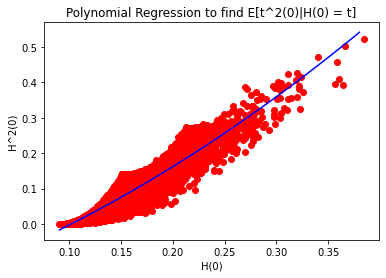

In [88]:
p3 = conditional_expectation(i = 7,h0 = h0,H20 = H20, degree = 2)

In [89]:
# Differentiation of the lmabda function using the gression coefficients and the mean and std values from fitted normal distribution in R
V = sym.symbols('v_alpha')
equation = sym.exp(-0.5*((V - 0.19163591)/1.066057)**2)*(p3[0]+ p3[1]*(V) + p3[2]*(V**2))/(np.sqrt(2*3.14)*1.066057)
dx = sym.diff(equation,V)
A = format(dx)
print('After differentiation:',A)
lambda_cap.append(A)

After differentiation: (0.16862270076196 - 0.879911811736953*v_alpha)*(0.611612403985915*v_alpha**2 + 0.431909625542339*v_alpha)*exp(-0.439955905868476*(v_alpha - 0.19163591)**2) + (1.22322480797183*v_alpha + 0.431909625542339)*exp(-0.439955905868476*(v_alpha - 0.19163591)**2)


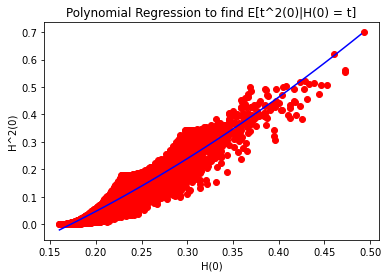

In [90]:
p3 = conditional_expectation(i = 8,h0 = h0,H20 = H20, degree = 2)

In [91]:
# Differentiation of the lmabda function using the gression coefficients and the mean and std values from fitted normal distribution in R
V = sym.symbols('v_alpha')
equation = sym.exp(-0.5*((V - 0.27538893)/1.195472)**2)*(p3[0]+ p3[1]*(V) + p3[2]*(V**2))/(np.sqrt(2*3.14)*1.195472)
dx = sym.diff(equation,V)
A = format(dx)
print('After differentiation:',A)
lambda_cap.append(A)

After differentiation: (0.192693764527249 - 0.699714997720674*v_alpha)*(0.534048791257557*v_alpha**2 + 0.375405850822305*v_alpha)*exp(-0.349857498860337*(v_alpha - 0.27538893)**2) + (1.06809758251511*v_alpha + 0.375405850822305)*exp(-0.349857498860337*(v_alpha - 0.27538893)**2)


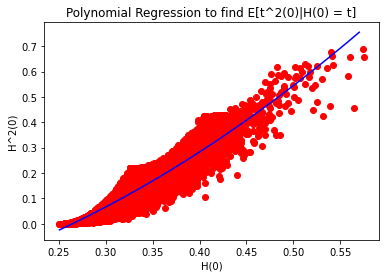

In [92]:
p3 = conditional_expectation(i = 9,h0 = h0,H20 = H20, degree = 2)

In [93]:
# Differentiation of the lmabda function using the gression coefficients and the mean and std values from fitted normal distribution in R
V = sym.symbols('v_alpha')
equation = sym.exp(-0.5*((V - 0.37691170)/1.177538)**2)*(p3[0]+ p3[1]*(V) + p3[2]*(V**2))/(np.sqrt(2*3.14)*1.177538)
dx = sym.diff(equation,V)
A = format(dx)
print('After differentiation:',A)
lambda_cap.append(A)

After differentiation: (0.271825225431231 - 0.721190733615409*v_alpha)*(0.754948743600457*v_alpha**2 + 0.205111615176619*v_alpha)*exp(-0.360595366807704*(v_alpha - 0.3769117)**2) + (1.50989748720091*v_alpha + 0.205111615176619)*exp(-0.360595366807704*(v_alpha - 0.3769117)**2)


In [167]:
# Estimating the Value at risk using OCBA
from sympy.parsing.sympy_parser import parse_expr
from numpy import exp as exp

def ocba_uniform_real(weights_list, Tb, N0, K, d):
    np.random.seed(1)
    v = []
    bias = []
    variance = []
    new_count = [N0]*len(weights_list)
    last_count =  [N0]*len(weights_list)
    h_mean = [[] for i in range(len(weights_list))]
    sn_ratio = [0 for i in range(len(weights_list))]
    all_ratio = [0 for i in range(len(weights_list))]
    l = 0
    
    #Initialization
    for i in range(len(weights_list)):
        for n in range(0 , new_count[i]):
            O = float(np.random.choice(effr, 1, replace=True)[0])
            h = []
            for k in range(0 , K):
                ht = sample_path(x0=0.5, x=weights_list[i], X=3, S0=float(S0), r=0.1, T=0.25, t=1/52, c=1, mu=float(mean_price), sigma=float(vol_daily), O=O)
                h.append(ht)
            h_mean[i].append(np.mean(h))
        sorted_vi = sorted(h_mean[i])
        v_alpha = sorted_vi[int(np.floor(0.90*new_count[i]))]
        v.append(v_alpha)
        ft = float(f[i].evaluate(v_alpha))
        if np.round(ft,4) == 0.0:
            bias.append(float(-1*(np.round(eval(lambda_cap[i]),4))/np.round((ft + 0.0001), 4))) # adding a small number to ft since division by zero is not possible
            variance.append(float(float(np.sqrt(0.09)/np.round((ft + 0.0001),4))))
        else:
            bias.append(float(-1*(np.round(eval(lambda_cap[i]), 4))/np.round(ft,4)))
            variance.append(float(np.sqrt(0.09)/np.round(ft, 4)))
    Tu = np.sum(last_count)*(K)
    
    #Looping till full budget is reached
    while Tu < Tb:
        bk = [i / K for i in bias]
        b_list = []
        for e in range(len(v)):
            b_list.append(v[e] - bk[e])
        b = np.argmin(b_list)
        b_factor =0
        for j in range(len(weights_list)):
            if j == b:
                continue
            else:
                sn_ratio[j] = variance[j] / ((v[b] - bias[b]/K) -(v[j] - bias[j]/K)) ** 2 # calculating the signal to noise ratio for OCBA allocation scheme
                b_factor += (sn_ratio[j])**2 / variance[j]
        sn_ratio[b] = np.sqrt(variance[b]) * np.sqrt(b_factor)
        sum_sn_ratio = np.sum(np.array(sn_ratio))
        sum_last_count = np.sum(np.array(last_count))
        
        for wts in range(len(weights_list)):
            all_ratio[wts] = sn_ratio[wts] / sum_sn_ratio
            new_count[wts] = all_ratio[wts] * (d + sum_last_count) # new allocation using OCBA


        for i in range(len(weights_list)):
            for n in range(int(np.floor(max(new_count[i] - last_count[i],0)))):
                O = float(np.random.choice(effr, 1, replace=True)[0])
                h = []
                for k in range(0 , K):
                    ht = sample_path(x0=0.5, x=weights_list[i], X=3, S0=float(S0), r=0.1, T=0.25, t=1/52, c=1, mu=float(mean_price), sigma=float(vol_daily), O=O)
                    h.append(ht)
                h_mean[i].append(np.mean(h)) 
            sorted_vi = sorted(h_mean[i])
            v_alpha = sorted_vi[int(np.floor(0.90*len(h_mean[i])))]
            v[i] = v_alpha
            ft = float(f[i].evaluate(v_alpha))
            if np.round(ft,4) == 0:
                bias[i] = float(-1*(np.round(eval(lambda_cap[i]),4))/np.round((ft + 0.0001), 4))  # adding a small number to ft since division by zero is not possible
                variance[i] = float(np.sqrt(0.09)/np.round((ft + 0.0001), 4))
            else:
                bias[i] = float(-1*(np.round(eval(lambda_cap[i]), 4))/np.round(ft,4))
                variance[i] = float(float(np.sqrt(0.09)/np.round(ft,4)))
        last_count = new_count
        l = l + 1
        Tu = np.sum(last_count)*(K)
    
    print('The lowest Value-at-risk:', min(v), 'for weight:', weights_list[v.index(min(v))])
    print('Total simulation budget used:', Tb)

In [183]:
w = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
ocba_uniform_real(w, Tb=1000000, N0=100, K=100, d=10)

The lowest Value-at-risk: 0.050674766247836206 for weight: 0.4
Total simulation budget used: 1000000


In [165]:
def correct_selection_ocba_uniform(Mn,cv,weights_list, Tb, N0, K, d):
    np.random.seed(1)
    u = []
    for j in range(0,Mn):
        v = []
        bias = []
        variance = []
        new_count = [N0]*len(weights_list)
        last_count =  [N0]*len(weights_list)
        h_mean = [[] for i in range(len(weights_list))]
        sn_ratio = [0 for i in range(len(weights_list))]
        all_ratio = [0 for i in range(len(weights_list))]
        l = 0
        
        #Initialization
        for i in range(len(weights_list)):
            for n in range(0 , new_count[i]):
                O = float(np.random.choice(effr, 1, replace=True)[0])
                h = []
                for k in range(0 , K):
                    ht = sample_path(x0=0.5, x=weights_list[i], X=3, S0=float(S0), r=0.1, T=0.25, t=1/52, c=1, mu=float(mean_price), sigma=float(vol_daily), O=O)
                    h.append(ht)
                h_mean[i].append(np.mean(h))
            sorted_vi = sorted(h_mean[i])
            v_alpha = sorted_vi[int(np.floor(0.90*new_count[i]))]
            v.append(v_alpha)
            ft = float(f[i].evaluate(v_alpha))
            if np.round(ft,4) == 0.0:
                bias.append(float(-1*(np.round(eval(lambda_cap[i]),4))/np.round((ft + 0.0001), 4))) # adding a small number to ft since division by zero is not possible
                variance.append(float(float(np.sqrt(0.09)/np.round((ft + 0.0001),4))))
            else:
                bias.append(float(-1*(np.round(eval(lambda_cap[i]), 4))/np.round(ft,4)))
                variance.append(float(np.sqrt(0.09)/np.round(ft, 4)))
        Tu = np.sum(last_count)*(K)

        #Looping till full budget is reached
        while Tu < Tb:
            bk = [i / K for i in bias]
            b_list = []
            for e in range(len(v)):
                b_list.append(v[e] - bk[e])
            b = np.argmin(b_list)
            b_factor =0
            for j in range(len(weights_list)):
                if j == b:
                    continue
                else:
                    sn_ratio[j] = variance[j] / ((v[b] - bias[b]/K) -(v[j] - bias[j]/K)) ** 2 # calculating the signal to noise ratio for OCBA allocation scheme
                    b_factor += (sn_ratio[j])**2 / variance[j]
            sn_ratio[b] = np.sqrt(variance[b]) * np.sqrt(b_factor)
            sum_sn_ratio = np.sum(np.array(sn_ratio))
            sum_last_count = np.sum(np.array(last_count))

            for wts in range(len(weights_list)):
                all_ratio[wts] = sn_ratio[wts] / sum_sn_ratio
                new_count[wts] = all_ratio[wts] * (d + sum_last_count) # new allocation using OCBA


            for i in range(len(weights_list)):
                for n in range(int(np.floor(max(new_count[i] - last_count[i],0)))):
                    O = float(np.random.choice(effr, 1, replace=True)[0])
                    h = []
                    for k in range(0 , K):
                        ht = sample_path(x0=0.5, x=weights_list[i], X=3, S0=float(S0), r=0.1, T=0.25, t=1/52, c=1, mu=float(mean_price), sigma=float(vol_daily), O=O)
                        h.append(ht)
                    h_mean[i].append(np.mean(h)) 
                sorted_vi = sorted(h_mean[i])
                v_alpha = sorted_vi[int(np.floor(0.90*len(h_mean[i])))]
                v[i] = v_alpha
                ft = float(f[i].evaluate(v_alpha))
                if np.round(ft,4) == 0:
                    bias[i] = float(-1*(np.round(eval(lambda_cap[i]),4))/np.round((ft + 0.0001), 4)) # adding a small number to ft since division by zero is not possible
                    variance[i] = float(np.sqrt(0.09)/np.round((ft + 0.0001), 4))
                else:
                    bias[i] = float(-1*(np.round(eval(lambda_cap[i]), 4))/np.round(ft,4))
                    variance[i] = float(float(np.sqrt(0.09)/np.round(ft,4)))
            last_count = new_count
            l = l + 1
            Tu = np.sum(last_count)*(K)
        
        ui = weights_list[v.index(min(v))]
        u.append(ui)
        
    p = prob(u,cv)
    return p

In [184]:
P1 = []
a1 = np.arange(10000,60000,10000)
for i in a1:
    p1 = correct_selection_ocba_uniform(Mn = 500,cv = 0.4,weights_list = w, Tb = i, N0 = 100 , K = 40, d = 10)
    P1.append(p1)
print(P1)

[0.638, 0.604, 0.658, 0.646, 0.75]


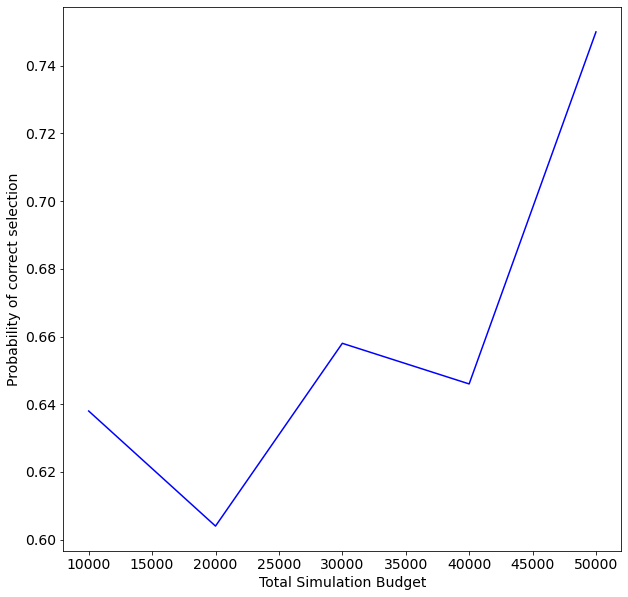

In [222]:
#Plotting the change in PCS with increase in total simulation budget
plt.plot(a1,P1,'-b')
plt.xlabel('Total Simulation Budget')
plt.ylabel("Probability of correct selection")
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})
plt.show()

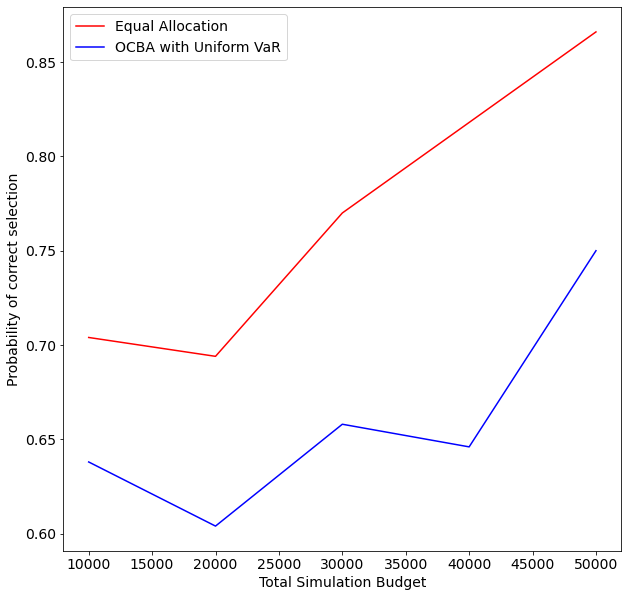

In [220]:
#Comparison of PCS for both Equal Allocation and OCBA uniform VaR 
plt.plot(a,P,'-r', label='Equal Allocation')
plt.plot(a1,P1,'-b', label='OCBA with Uniform VaR')
plt.xlabel('Total Simulation Budget')
plt.ylabel("Probability of correct selection")
plt.legend()
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 10})
plt.show()